# Continuum mechanics -- crack tip stress

In this lesson we will look at the stress distribution around a crack tip. Here we switch from atomistic simulations to continuum mechanics with the finite element method (FEM) using the [FEniCS code](https://fenicsproject.org) under the hood. 

We won't spend very much time on the mathematics for FEM, but will examine some of the common input parameters and their effect.

For physics, we will examine three fracture modes for a simple triangular crack in a cubic sample. This is shown schematically below courtesy of wikipedia for a rectangular prism:

![wikipedia fracture mechanics](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Fracture_modes_v2.svg/2560px-Fracture_modes_v2.svg.png)

# Setup

In [1]:
%matplotlib notebook
from pyiron_base import Project
import pyiron_contrib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pr = Project('lesson3')
pr.remove_jobs_silently(recursive=True)

# FEM basics

FEM is an approach for solving partial differential equations (PDEs) numerically by discretizing them with a mesh and using the calculus of variations. 

The key physical concepts which specify the problem are the equation being solved (obviously), the spatial domain on which this equation is being solved, and the boundary conditions on that domain. The last of these is typically broken down into two varieties: "Dirichlet" boundary conditions, which specify the value of the field being solved for, and "Neumann" boundary conditions, which specify the gradient of that field dotted with the domain normal vector.

Some of the important numerical concepts are the mesh generation (we will look in a bit of detail at the effect of mesh density) and the element order, which controls how the fields are interpolated within the individual elements (which we will touch on only briefly).

There is much, much more depth on both the mathematical and numeric sides of FEM, but it is not my core area of research and from here on we will restrict ourselves to a concrete example.

## Linear Elasticity

The static solution to linear elasticity can be summarized with three equations:

1. $\nabla \cdot \sigma = -f$
2. $\sigma = \lambda~\mathrm{tr}(\epsilon) \mathrm{I} + 2 \mu \epsilon$
3. $\epsilon = \frac{1}{2}\left(\nabla u + (\nabla u)^\mathrm{T} \right)$

Where the derivatives of the stress tensor, $\sigma$ balance out body forces on the sample, $f$. The stress tensor is shown here using Lame's constants $\lambda$ and $\mu$ -- which we can also describe in terms of very familair bulk ($K$) and shear ($G$) moduli as $\lambda = K - (2 G / 3)$ and $\mu = G$ -- and the symmeterized strain rate tensor, $\epsilon$, which in turn is constructed from gradients of the displacement field $u$.

With FEM we convert this the so-called weak form which contains integrals and a test function `v`. In this form, we solve

$\int_\Omega \sigma(u):\epsilon(v) dx = \int_\Omega f \cdot v dx + \int_{\partial \Omega_T} T \cdot v ds$

Where $\Omega$ is the domain of our sample and $\partial \Omega_T$ is its boundaries subject to the traction $T$ (remaining boundaries are subject to Dirichlet conditions where the solution is given directly), and $:$ is a tensor contraction. 

For the problems we look at here both $f$ and $T$ will be strictly zero, i.e. we have a linear elastic material subject to boundaries which are either displacement controlled or free to relax with no external forces on them. So the physcis of our solution (displacement and strain) is controlled by our material properties ($K$ and $G$ moduli), the geometry of our sample, and how we control its deformation with Dirichlet boundary conditions.

# Geometry

We'll create our sample by making a box, then subtracting out a triangular crack from this domain. The code to do this is nicely wrapped up in the function below, `set_domain_to_cracked_box`. The important thing for us is that we can easily play around with the crack length, width, and depth (in the x-, y-, z-directions of our box, respectively).

In [3]:
def set_domain_to_cracked_box(job, crack_length=1.0, crack_width=0.1, crack_depth=0.5):
    """
    Sets the job's domain to a unit box with a triangular crack tip in it. The crack starts at the
    z=0 plane running along the x-axis.

    The domain is initially a box, then we subtract out a triangular wedge made from three tets.
    The mesh generation is not perfect and there can be small defects right at the crack tip.

    Args:
        job (Fenics): The job whose domain to set.
        crack_length (float): How long the crack is. (Default is 1, run the entire length of the box.)
        crack_width (float): How wide the mouth of the crack is. (Default is 0.1.)
        crack_depth (float): How deep the crack is. (Default is 0.5, reach to the center of the box.
    """
    bulk = job.create.domain.box()
    p1 = (0.5 * (1 - crack_length), 0.5 * (1 - crack_width), 0.)
    p2 = (0.5 * (1 - crack_length), 0.5 * (1 + crack_width), 0.)
    p3 = (0.5 * (1 + crack_length), 0.5 * (1 + crack_width), 0.)
    p4 = (0.5 * (1 + crack_length), 0.5 * (1 - crack_width), 0.)
    p5 = (0.5 * (1 - crack_length), 0.5, crack_depth)
    p6 = (0.5 * (1 + crack_length), 0.5, crack_depth)
    crack1 = job.create.domain.tetrahedron(p1, p2, p3, p5)
    # crack2 = job.create.domain.tetrahedron(p1, p2, p3, p6)
    # crack3 = job.create.domain.tetrahedron(p1, p2, p4, p5)
    # crack4 = job.create.domain.tetrahedron(p1, p2, p4, p6)
    # crack5 = job.create.domain.tetrahedron(p1, p2, p5, p6)
    # crack6 = job.create.domain.tetrahedron(p1, p3, p4, p5)
    crack7 = job.create.domain.tetrahedron(p1, p3, p4, p6)
    crack8 = job.create.domain.tetrahedron(p1, p3, p5, p6)
    # crack9 = job.create.domain.tetrahedron(p2, p3, p4, p5)
    # crack10 = job.create.domain.tetrahedron(p2, p3, p4, p6)
    # crack11 = job.create.domain.tetrahedron(p3, p4, p5, p6)
    job.domain = bulk - crack1 - crack7 - crack8

Let's create a new FEniCS FEM job and examine the behaviour of this function. In addition to the geometry, we will also increase the mesh density from its very low default value of `2`.

In [4]:
job = pr.create.job.FenicsLinearElastic('fem')

In [5]:
set_domain_to_cracked_box(job)
job.input.mesh_resolution = 10

Now let's visualize the mesh

In [6]:
job.mesh

## Exercise 1

Play around with the `crack_length`, `crack_width`, and `crack_depth` arguments until you comfortably understand the effect they have on the sample geometry. Then increase the `input.mesh_resolution` and note its impact on both the overall meshing, and especially on the numeric artefacts right at the tip.

Note: After calling `set_domain_to_cracked_box` again and/or changing the `job.input.mesh_resolution`, you will need to call `job.generate_mesh()` to update the mesh to use the new parameters.

In [7]:
set_domain_to_cracked_box(job, crack_length=1., crack_width=0.2, crack_depth=0.5)
job.input.mesh_resolution = 40
job.generate_mesh()
job.mesh

# Solving for displacement and stress

Let's solve the displacement and von Mises stress for mode 1: openening. This calculation will serve as an example of how the syntax works for the other calculations we'll perform.

## Running the calculation

First, we'll instantiate the job and set the material properties, for which we'll use experimental values for Al reported [on wikipedia](https://en.wikipedia.org/wiki/Aluminium) in GPa.

In [8]:
mode1 = pr.create.job.FenicsLinearElastic('mode1', delete_existing_job=True)
K_Al, G_Al = 76, 26
mode1.input.bulk_modulus = K_Al
mode1.input.shear_modulus = G_Al

Next, we'll apply a technical setting: switch the solver from its default value of direct solution to an iterative solver. This allows us to increase the mesh density to larger values without running out of memory. If you want to know more details about FEM solvers, you can read about them [here](https://www.simscale.com/blog/2016/08/how-to-choose-solvers-for-fem/). For our purposes it's sufficient to know that we're switching over to an iterative solver.

In [9]:
mode1.input.solver_parameters = {
    'linear_solver': 'gmres',
    'preconditioner': 'ilu'
}

After this, we'll construct our geometry. We saw above how the constructor works, but we also want to be able to find nodes that belong to the boundaries so we can apply boundary conditions.

In [10]:
mode1.input.mesh_resolution = 30
set_domain_to_cracked_box(mode1)

FEniCS, which pyiron is using under the hood, does this with a special python function that takes two arguments: the position of the node, `x`, which is three-dimensional for us, and a boolean array `on_boundary` which FEniCS uses internally to keep track of which nodes are on *any* boundary.

For our boundary conditions, we'll hold the end of the sample opposite the crack fixed, and then displace the face of the sample where the crack starts according to which deformation mode we want. For this, we'll need functions to find the face where the crack *starts* and *ends*, as well as functions to see if we have the *top* half of the face above the crack or the *bottom* half of the face below it.

Using `set_domain_to_cracked_box`, our crack penetrates along the z-axis runs the length of the x-axis, i.e. whether we're above or below it is determined by our y-position. Thus, our logical conditions will use `x[2]` (z) and `x[1]` (y).

In [11]:
def near_start(x, on_boundary):
    return job.fenics.near(x[2], 0.)

def near_end(x, on_boundary):
    return job.fenics.near(x[2], 1.)

def top_half(x, on_boundary):
    return on_boundary and x[1] > 0.5 and near_start(x, on_boundary)

def bottom_half(x, on_boundary): 
    return on_boundary and x[1] < 0.5 and near_start(x, on_boundary)

Our actual boundary conditions will be "Dirichlet" (i.e. displacement) conditions on these faces. To communicate these to FEniCS we use special data types called `Constant` (for things that don't change, obviously) and `Expression` (in case we have something with variables). Here let's just apply a static strain using `Constant`.

Activating mode 1, we'll move the top half up a bit and the bottom half down a bit in the y-direction:

In [12]:
strain = 0.01
top_bc = mode1.create.bc.dirichlet(mode1.Constant((0, strain, 0)), top_half)
bottom_bc = mode1.create.bc.dirichlet(mode1.Constant((0, -strain, 0)), bottom_half)
rigid_bc = mode1.create.bc.dirichlet(mode1.Constant((0, 0, 0)), near_end)

These boundary conditions (BCs) get applied to the job as a list.

In [13]:
mode1.BC = [rigid_bc, top_bc, bottom_bc]

Now all that's left to do is run our job.

Note: FEniCS funcitonality in pyiron is still experimental, so unlike other jobs which get automatically saved and can be re-loaded later, these jobs exist only in the notebook. Thankfully for us, this problem does not use very much CPU time, so we can always simply re-run the calculations without too much headache.

In [14]:
mode1.run()

The job mode1 was saved and received the ID: 222


## Analyzing run

The main output from this run is the displacement field (i.e. the `solution`) and the von Mises stress, which is a scalar field value we post-process from the solution and indicates where plastic activity is most likely to start: $\sigma_M = \sqrt{\frac{3}{2}s : s}$, where $s = \sigma - \frac{1}{3}\mathrm{tr}(\sigma)\mathrm{I}$ is the deviatoric strain.

Let's start by looking at a 3D plot of this stress:

<IPython.core.display.Javascript object>


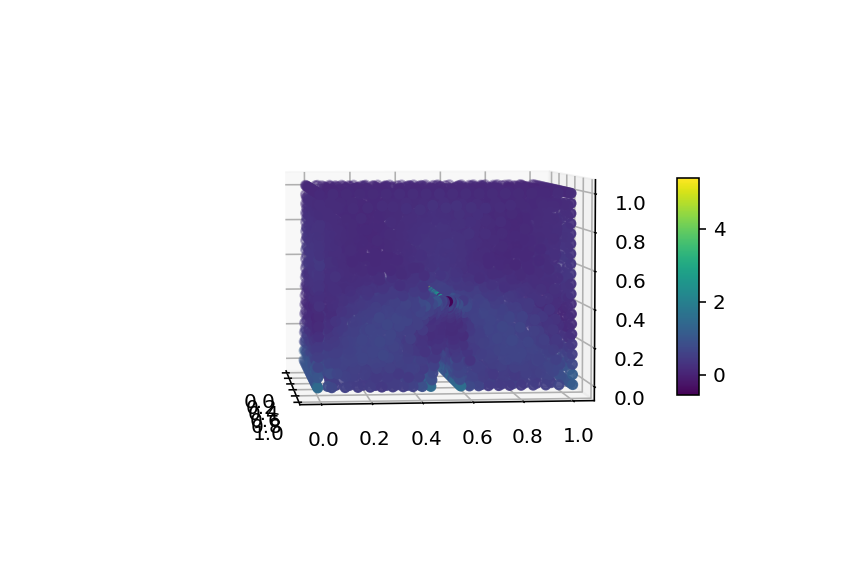

(<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x7ff81a54f3a0>,
 <Figure size 432x288 with 2 Axes>,
 <Axes3DSubplot:>)

In [49]:
mode1.plot.stress3d()

Reassuringly, there is a line of high-stress dots along the very tip of the crack, as we would expect. Otherwise most of the stress seems to be focused in the half of the sample containing the crack.

3D plots are useful, but sometimes it is more effective to look at some 2D projection. We also have helper functions to do this, which project all the results onto a single plane. Since we'd like to isolate the crack tip, it's helpful to project on the x-axis onto the yz-plane so that we're looking down the length of the crack.

<IPython.core.display.Javascript object>


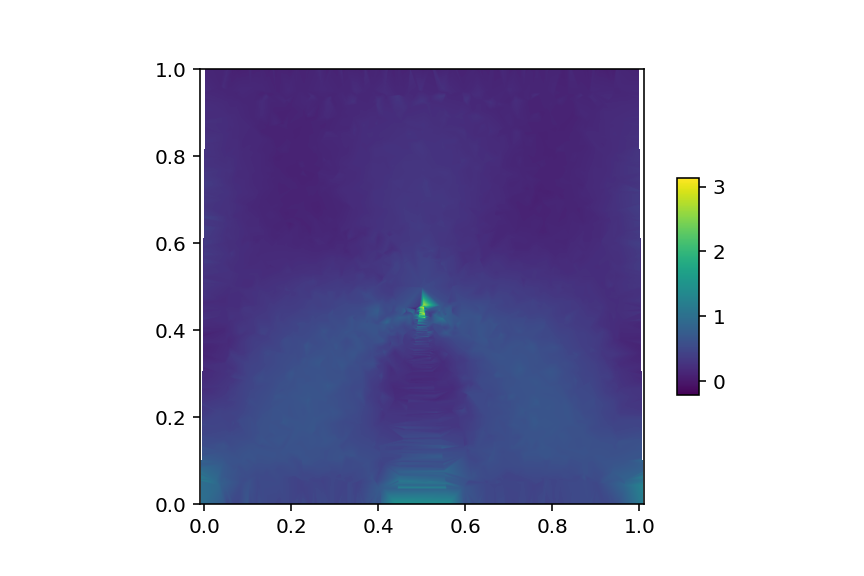

In [16]:
mode1.plot.stress2d(projection_axis=0);

Oh no! Where did our crack go?

Actually, it is still there -- this is just a simple interpolating colourmap, so along the crack where we have no data the plot is simply interpolating. This is actually visible: if you look carfully you will see that there is a triangle with its base on the horizontal axis that has horizontal striated colour bands where the interpolation is happening from one side of the open crack to the other.

As with the 3D plot, but a bit easier to see now, the stress is indeed focused at the tip of the crack. It's so focused that this bright spot actually washes out information about the rest of the stress distribution. We can get around this by using a logarithmic scaling for our colours:

<IPython.core.display.Javascript object>


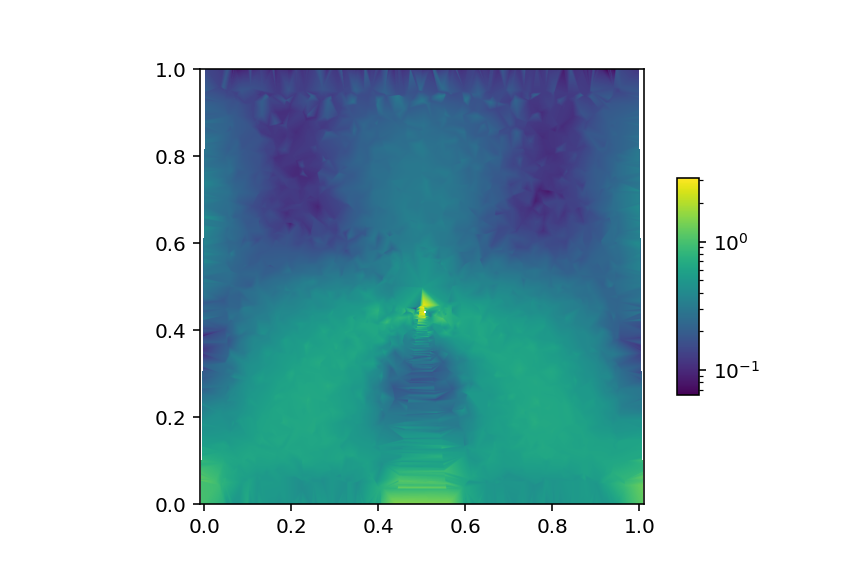

In [17]:
mode1.plot.stress2d(projection_axis=0, lognorm=True);

Finally, we might also be interested in the raw numeric values -- like what is the maximum nodal stress value? These nodal values are stored in the output:

In [18]:
print("Max nodal stress = {}".format(mode1.output.von_Mises[-1].max()))

Max nodal stress = 5.389674651068005


###  Thinking Deeper

Which mode do you expect will have the largest maximum stress, which the smallest, and why?

*Your thoughts here*

### Exercise

Let's get some data to test your hypothesis! Run the same calculation for the other two modes; examine the stress plots and directly compare the maximum stresses. Does the data support your hypothesis, or illuminate something new?

Hint: We only need to change the displacements in our Dirichlet boundary conditions.

In [19]:
# Your code here

The job mode2 was saved and received the ID: 223


<IPython.core.display.Javascript object>


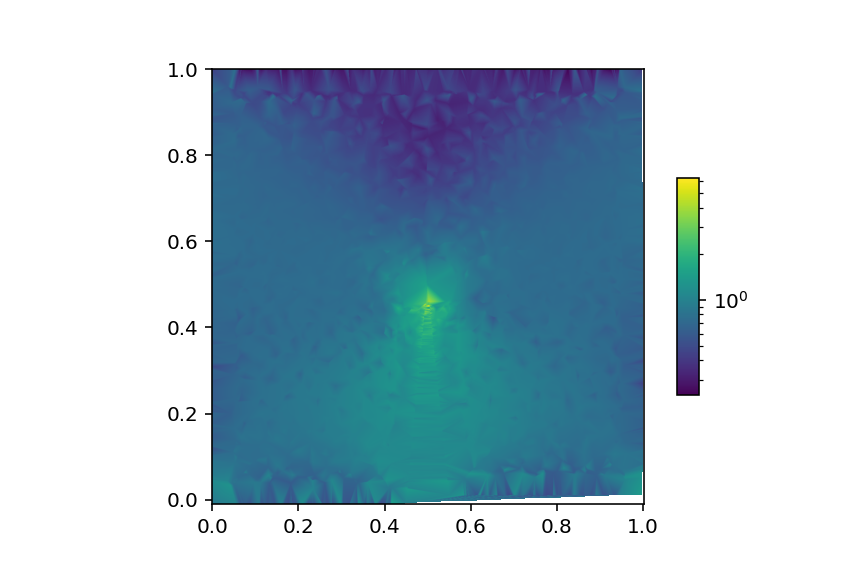

In [20]:
mode2 = pr.create.job.FenicsLinearElastic('mode2', delete_existing_job=True)

mode2.input.bulk_modulus = mode1.input.bulk_modulus
mode2.input.shear_modulus = mode1.input.shear_modulus
mode2.input.solver_parameters = mode1.input.solver_parameters
mode2.input.mesh_resolution = mode1.input.mesh_resolution

set_domain_to_cracked_box(mode2)

top_bc = mode2.create.bc.dirichlet(mode2.Constant((0, 0, strain)), top_half)
bottom_bc = mode2.create.bc.dirichlet(mode2.Constant((0, 0, -strain)), bottom_half)
rigid_bc = mode2.create.bc.dirichlet(mode2.Constant((0, 0, 0)), near_end)
mode2.BC = [rigid_bc, top_bc, bottom_bc]

mode2.run()

mode2.plot.stress2d(projection_axis=0, lognorm=True);

The job mode3 was saved and received the ID: 224


<IPython.core.display.Javascript object>


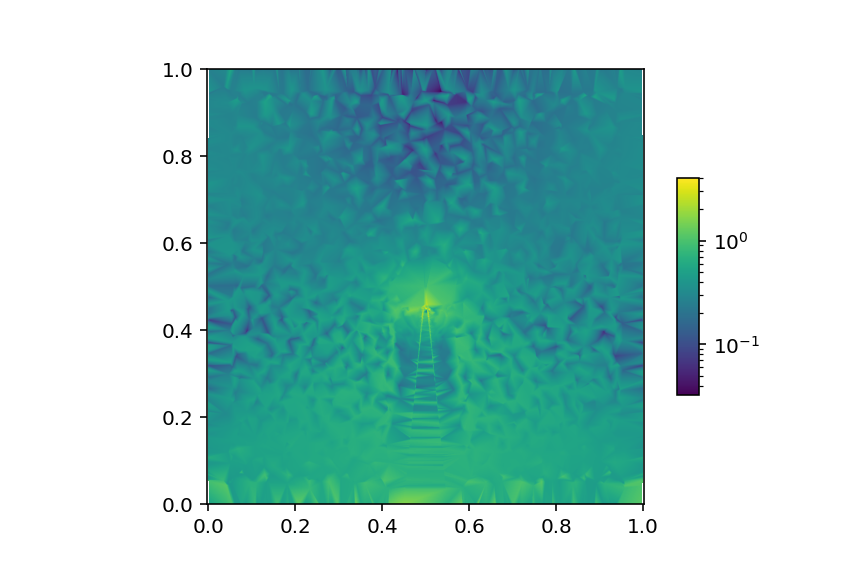

In [21]:
mode3 = pr.create.job.FenicsLinearElastic('mode3', delete_existing_job=True)

mode3.input.bulk_modulus = mode1.input.bulk_modulus
mode3.input.shear_modulus = mode1.input.shear_modulus
mode3.input.solver_parameters = mode1.input.solver_parameters
mode3.input.mesh_resolution = mode1.input.mesh_resolution

set_domain_to_cracked_box(mode3)

top_bc = mode3.create.bc.dirichlet(mode3.Constant((strain, 0, 0)), top_half)
bottom_bc = mode3.create.bc.dirichlet(mode3.Constant((-strain, 0, 0)), bottom_half)
rigid_bc = mode3.create.bc.dirichlet(mode3.Constant((0, 0, 0)), near_end)
mode3.BC = [rigid_bc, top_bc, bottom_bc]

mode3.run()

mode3.plot.stress2d(projection_axis=0, lognorm=True);

In [22]:
print("Mode 1 max nodal stress = {}".format(mode1.output.von_Mises[-1].max()))
print("Mode 2 max nodal stress = {}".format(mode2.output.von_Mises[-1].max()))
print("Mode 3 max nodal stress = {}".format(mode3.output.von_Mises[-1].max()))

Mode 1 max nodal stress = 5.389674651068005
Mode 2 max nodal stress = 7.277245295910909
Mode 3 max nodal stress = 4.47609136602561


# Quasistatic strain profiles

You may have noticed that just like atomistic output we looked at the output with a `[-1]`, i.e. `job.output.von_Mises[-1]`. That's because just like the atomistic data we can look at a time series of results.

In this case, it's fairly easy to set up an experiment studying the stress as a function of increasing strain in the quasistatic limit (i.e. ignoring any sort of momentum effects, etc.). The key difference will be that our boundary conditions are now a time (`t`) dependent `Expression` instead of a `Constant`. 

In [23]:
mode1t = pr.create.job.FenicsLinearElastic('mode1t', delete_existing_job=True)
mode1t.input.bulk_modulus = K_Al
mode1t.input.shear_modulus = G_Al
mode1t.input.solver_parameters = {
    'linear_solver': 'gmres',
    'preconditioner': 'ilu'
}
mode1t.input.mesh_resolution = 30
set_domain_to_cracked_box(mode1t)

In [24]:
strain_step = 0.005
dirichlet_top = mode1t.Expression(('0', 'a * t', '0'), degree=2, a=strain_step, t=0)
dirichlet_bot = mode1t.Expression(('0', '-a * t', '0'), degree=2, a=strain_step, t=0)

top_bc = mode1t.create.bc.dirichlet(dirichlet_top, top_half)
bottom_bc = mode1t.create.bc.dirichlet(dirichlet_bot, bottom_half)
rigid_bc = mode1t.create.bc.dirichlet(mode1t.Constant((0, 0, 0)), near_end)
mode1t.BC = [rigid_bc, top_bc, bottom_bc]

Lastly, we need to let the job know which expressions are time-dependent so it can update their `t` parameter, and tell it how many steps to run for:

In [25]:
mode1t.time_dependent_expressions.append(dirichlet_top)
mode1t.time_dependent_expressions.append(dirichlet_bot)
mode1t.input.n_steps = 10

In [26]:
mode1t.run()

The job mode1t was saved and received the ID: 225


As before we can plot the output, but we can also choose which timestep to look at by setting the `frame` argument. Note how the top end of the stress plot is narrower and narrower compared to the bottom part as we apply more and more strain!

<IPython.core.display.Javascript object>


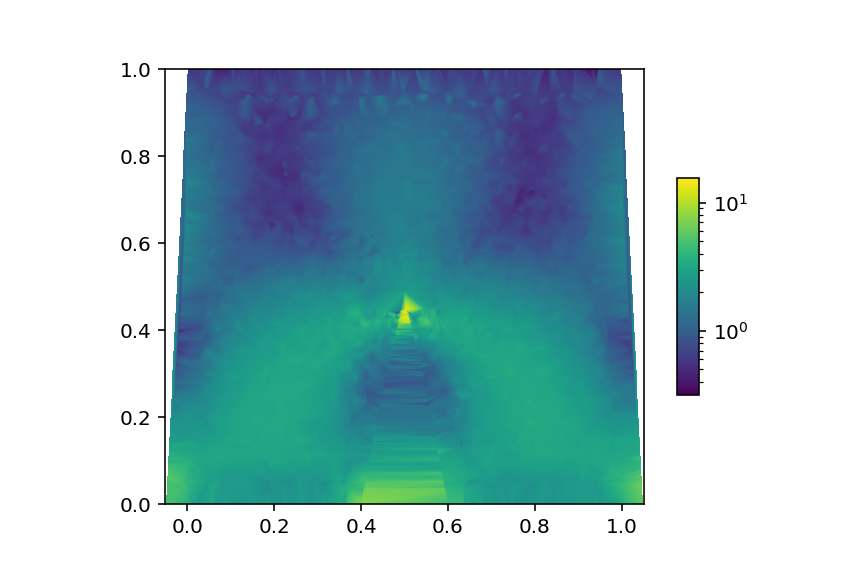

In [27]:
mode1t.plot.stress2d(frame=-1, projection_axis=0, lognorm=True);

We can also examine the peak stress as a function of strain:

<IPython.core.display.Javascript object>


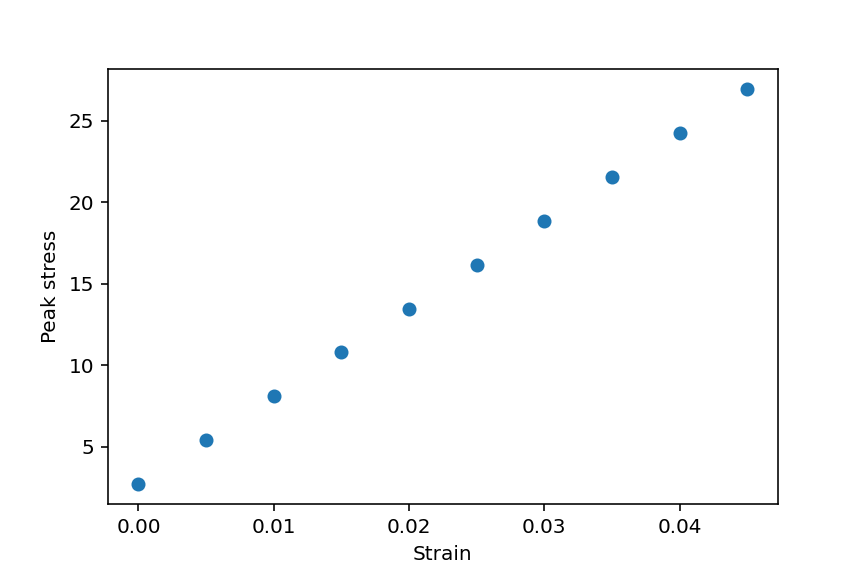

In [28]:
fig, ax = plt.subplots()  # A little bit of overhead because we're using interactive plots in this notebook
peak_stress_mode1t = np.array(mode1t.output.von_Mises).max(axis=1)
ax.scatter(strain_step * np.arange(len(peak_stress_mode1t)), peak_stress_mode1t)
ax.set_xlabel('Strain')
ax.set_ylabel('Peak stress');

## Exercise

What do the stress strain profiles look like for the other two deformation modes?

In [29]:
# Your code here

In [30]:
mode2t = pr.create.job.FenicsLinearElastic('mode2t', delete_existing_job=True)

mode2t.input.bulk_modulus = mode1t.input.bulk_modulus
mode2t.input.shear_modulus = mode1t.input.shear_modulus
mode2t.input.solver_parameters = mode1t.input.solver_parameters
mode2t.input.mesh_resolution = mode1t.input.mesh_resolution

set_domain_to_cracked_box(mode2t)

dirichlet_top = mode2t.Expression(('0', '0', 'a * t'), degree=2, a=strain_step, t=0)
dirichlet_bot = mode2t.Expression(('0', '0', '-a * t'), degree=2, a=strain_step, t=0)

top_bc = mode2t.create.bc.dirichlet(dirichlet_top, top_half)
bottom_bc = mode2t.create.bc.dirichlet(dirichlet_bot, bottom_half)
rigid_bc = mode2t.create.bc.dirichlet(mode2t.Constant((0, 0, 0)), near_end)
mode2t.BC = [rigid_bc, top_bc, bottom_bc]

mode2t.time_dependent_expressions.append(dirichlet_top)
mode2t.time_dependent_expressions.append(dirichlet_bot)
mode2t.input.n_steps = mode1t.input.n_steps

mode2t.run()

The job mode2t was saved and received the ID: 226


In [31]:
mode3t = pr.create.job.FenicsLinearElastic('mode3t', delete_existing_job=True)

mode3t.input.bulk_modulus = mode1t.input.bulk_modulus
mode3t.input.shear_modulus = mode1t.input.shear_modulus
mode3t.input.solver_parameters = mode1t.input.solver_parameters
mode3t.input.mesh_resolution = mode1t.input.mesh_resolution

set_domain_to_cracked_box(mode3t)

dirichlet_top = mode3t.Expression(('a * t', '0', '0'), degree=2, a=strain_step, t=0)
dirichlet_bot = mode3t.Expression(('-a * t', '0', '0'), degree=2, a=strain_step, t=0)

top_bc = mode3t.create.bc.dirichlet(dirichlet_top, top_half)
bottom_bc = mode3t.create.bc.dirichlet(dirichlet_bot, bottom_half)
rigid_bc = mode3t.create.bc.dirichlet(mode3t.Constant((0, 0, 0)), near_end)
mode3t.BC = [rigid_bc, top_bc, bottom_bc]

mode3t.time_dependent_expressions.append(dirichlet_top)
mode3t.time_dependent_expressions.append(dirichlet_bot)
mode3t.input.n_steps = mode1t.input.n_steps

mode3t.run()

The job mode3t was saved and received the ID: 227


<IPython.core.display.Javascript object>


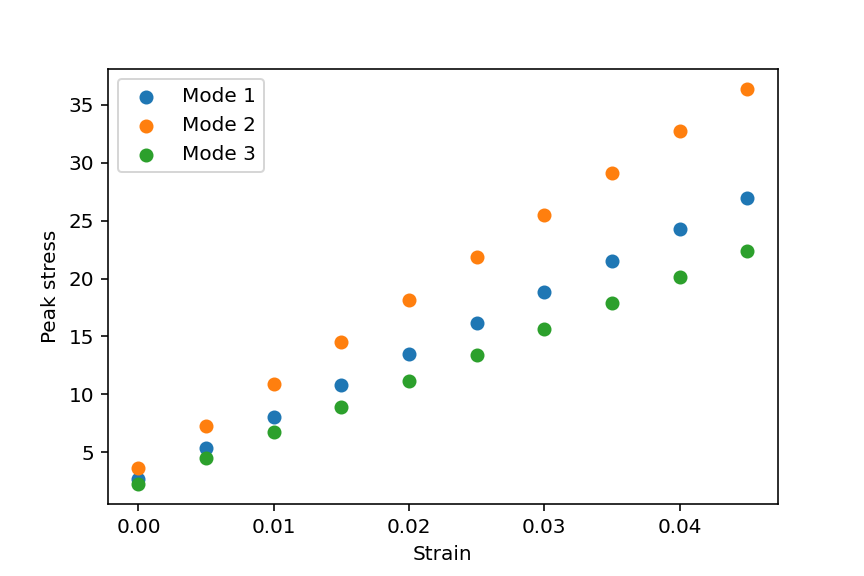

In [32]:
fig, ax = plt.subplots()  # A little bit of overhead because we're using interactive plots in this notebook
strain = strain_step * np.arange(mode1t.input.n_steps)
ax.scatter(strain, np.array(mode1t.output.von_Mises).max(axis=1), label='Mode 1')
ax.scatter(strain, np.array(mode2t.output.von_Mises).max(axis=1), label='Mode 2')
ax.scatter(strain, np.array(mode3t.output.von_Mises).max(axis=1), label='Mode 3')
ax.set_xlabel('Strain')
ax.set_ylabel('Peak stress')
ax.legend();

# Numerics

At the heart of FEM is a spatial discretization of our PDE, thus the mesh density for this discretization is a critical feature. Let's examine how our solution changes as a function of our numeric paramters.

Since changing the mesh density means the number and position of the nodes, we can't simply compare the output nodal positions. However, the stored solution at the end of the run can be evaluated at points other than just the mesh nodes by using the function defined below like `evaluate_solution(job.solution)`

In [33]:
spacing = np.linspace(0, 1, num=50)
x, y, z = np.meshgrid(spacing, spacing, spacing)
grid_points = np.vstack((x.flatten(), y.flatten(), z.flatten())).T

def evaluate_solution(solution, points=grid_points):
    values = []
    for p in points:
        try:
            values.append(solution(p))
        except RuntimeError:
            # There is no solution where we cut out the crack
            pass
    return np.array(values)

## Exercise

For a variety of mesh values, e.g. `[20, 30, 40, 50, 60]`, look at the root mean square difference of the solution on our uniform grid -- how does this converge as a function of the `input.mesh_resolution`? Use only your favourite deformation mode for this exercise, and a strain of 1%.

Note: we can't exploit the time-dependent expression here to do multiple mesh densities in a single calculation. Just make a regular for-loop and run multiple jobs.

Hint: You can get the magnitude of the difference between two arrays (of the same shape) very quickly using `np.linalg.norm(array1 - array2)`.

In [34]:
# Your code here

In [35]:
strain = 0.01
resolutions = np.linspace(20, 60, 5, dtype=int)

grid_solutions = []
mesh_jobs = []
for mesh_res in resolutions:
    mesh_job = pr.create.job.FenicsLinearElastic('mesh_{}'.format(mesh_res), delete_existing_job=True)

    mesh_job.input.bulk_modulus = K_Al
    mesh_job.input.shear_modulus = G_Al
    mesh_job.input.solver_parameters = mode1.input.solver_parameters
    mesh_job.input.mesh_resolution = mesh_res

    set_domain_to_cracked_box(mesh_job)

    top_bc = mesh_job.create.bc.dirichlet(mesh_job.Constant((0, strain, 0)), top_half)
    bottom_bc = mesh_job.create.bc.dirichlet(mesh_job.Constant((0, -strain, 0)), bottom_half)
    rigid_bc = mesh_job.create.bc.dirichlet(mesh_job.Constant((0, 0, 0)), near_end)
    mesh_job.BC = [rigid_bc, top_bc, bottom_bc]

    mesh_job.run()
    
    grid_solutions.append(evaluate_solution(mesh_job.solution))
    mesh_jobs.append(mesh_job)

The job mesh_20 was saved and received the ID: 228
The job mesh_30 was saved and received the ID: 229
The job mesh_40 was saved and received the ID: 230
The job mesh_50 was saved and received the ID: 231
The job mesh_60 was saved and received the ID: 232


In [36]:
magnitudes = [
    np.linalg.norm(grid_solutions[i+1] - grid_solutions[i]) for i in np.arange(len(grid_solutions) - 1)
]

<IPython.core.display.Javascript object>


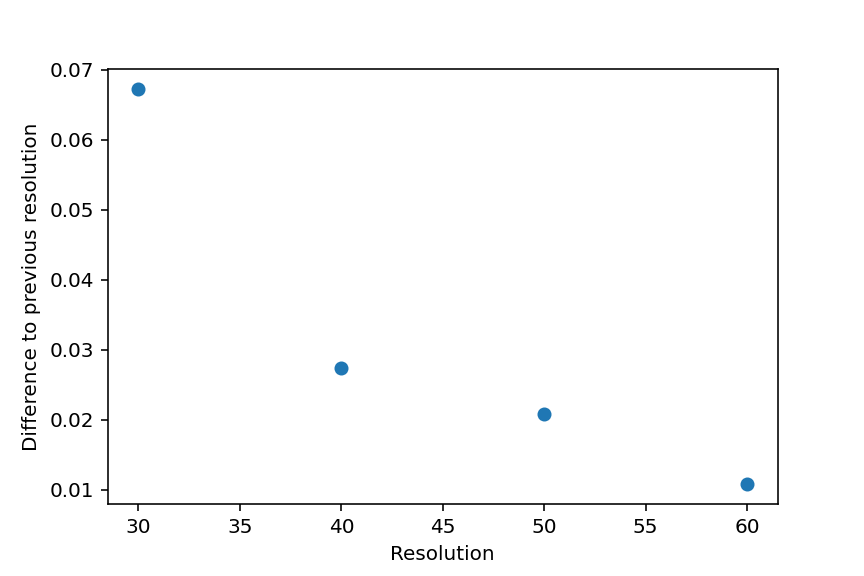

In [37]:
fig, ax = plt.subplots()
ax.scatter(resolutions[1:], magnitudes)
ax.set_xlabel('Resolution')
ax.set_ylabel('Difference to previous resolution');

## Exercise

So far we have been using the default value for `input.element_order` -- 1. That means that values are linearly interpolated throughout each individual finite element formed by our mesh.

Increase this value from 1 to 2, so that values are quadratically interpolated, and repeat the above exercise.

In [38]:
grid_solutions_2o = []
mesh_jobs_2o = []

for mesh_res in resolutions:
    mesh_job = pr.create.job.FenicsLinearElastic('mesh_2o_{}'.format(mesh_res), delete_existing_job=True)
    mesh_job.input.element_order = 2

    mesh_job.input.bulk_modulus = K_Al
    mesh_job.input.shear_modulus = G_Al
    mesh_job.input.solver_parameters = mode1.input.solver_parameters
    mesh_job.input.mesh_resolution = mesh_res

    set_domain_to_cracked_box(mesh_job)

    top_bc = mesh_job.create.bc.dirichlet(mesh_job.Constant((0, strain, 0)), top_half)
    bottom_bc = mesh_job.create.bc.dirichlet(mesh_job.Constant((0, -strain, 0)), bottom_half)
    rigid_bc = mesh_job.create.bc.dirichlet(mesh_job.Constant((0, 0, 0)), near_end)
    mesh_job.BC = [rigid_bc, top_bc, bottom_bc]

    mesh_job.run()
    
    grid_solutions_2o.append(evaluate_solution(mesh_job.solution))
    mesh_jobs_2o.append(mesh_job)

The job mesh_2o_20 was saved and received the ID: 233
The job mesh_2o_30 was saved and received the ID: 234
The job mesh_2o_40 was saved and received the ID: 235
The job mesh_2o_50 was saved and received the ID: 236
The job mesh_2o_60 was saved and received the ID: 237


In [39]:
magnitudes_2o = [
    np.linalg.norm(grid_solutions_2o[i+1] - grid_solutions_2o[i]) for i in np.arange(len(grid_solutions_2o) - 1)
]

<IPython.core.display.Javascript object>


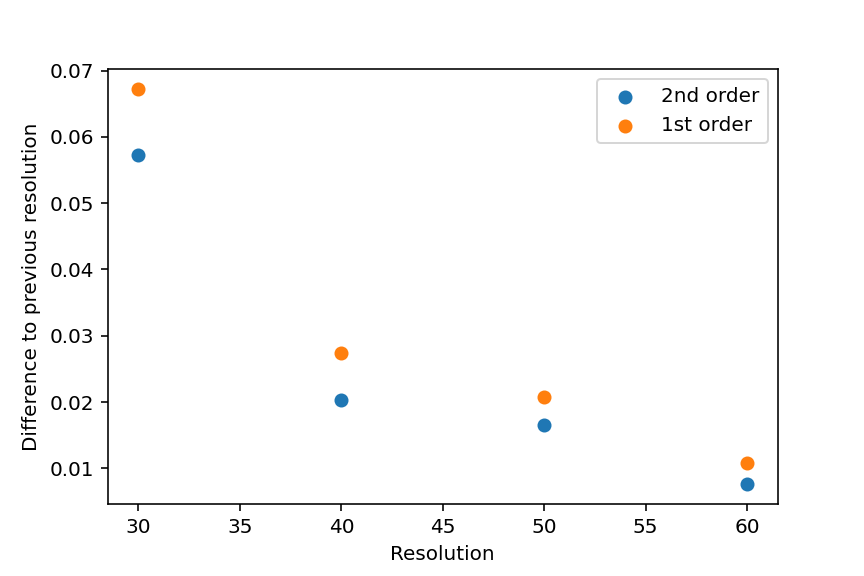

In [40]:
fig, ax = plt.subplots()
ax.scatter(resolutions[1:], magnitudes_2o, label='2nd order')
ax.scatter(resolutions[1:], magnitudes, label='1st order')
ax.set_xlabel('Resolution')
ax.set_ylabel('Difference to previous resolution')
ax.legend();

## Thinking deeper

Consider the relationship between mesh resolution and element order, their relative accuracy, and expense? What guidelines can we think of for when to use each setting?

<IPython.core.display.Javascript object>


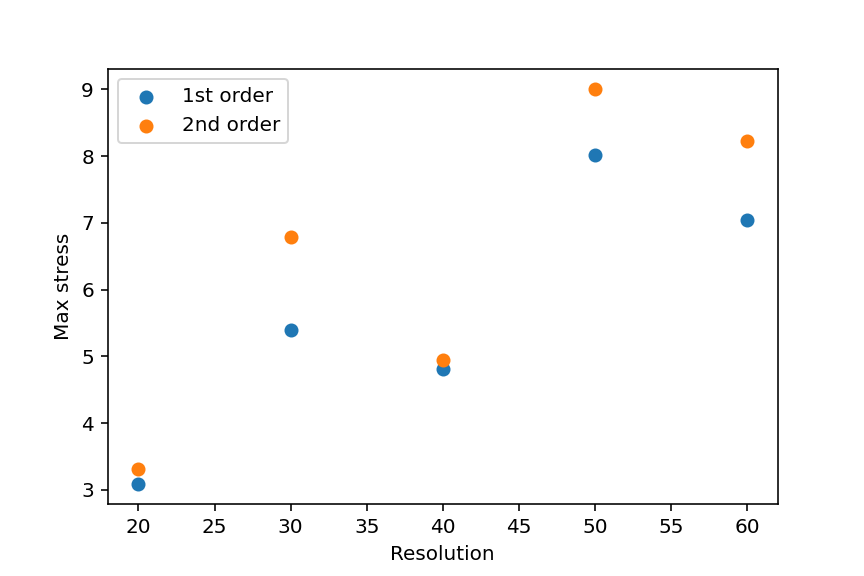

In [41]:
fig, ax = plt.subplots()
ax.scatter(resolutions, [job.output.von_Mises[-1].max() for job in mesh_jobs], label='1st order')
ax.scatter(resolutions, [job.output.von_Mises[-1].max() for job in mesh_jobs_2o], label='2nd order')
ax.set_xlabel('Resolution')
ax.set_ylabel('Max stress')
ax.legend();

# Physics

Finally, let's experiment with a couple of the actual material system parameters.

## Exercise

Increase the crack width smoothly from 0.1 of the sample width to 0.25. What is the effect on the maximum stress value? Does this agree with our textbook knowledge?

In [42]:
strain = 0.01
widths = np.linspace(0.1, 0.25, 10)

width_jobs = []
for w in widths:
    width_job = pr.create.job.FenicsLinearElastic(
        'width_{:.2f}'.format(w).replace('.', '_'), 
        delete_existing_job=True
    )

    width_job.input.bulk_modulus = K_Al
    width_job.input.shear_modulus = G_Al
    width_job.input.solver_parameters = mode1.input.solver_parameters
    width_job.input.mesh_resolution = 30

    set_domain_to_cracked_box(width_job, crack_width=w)

    top_bc = width_job.create.bc.dirichlet(width_job.Constant((0, strain, 0)), top_half)
    bottom_bc = width_job.create.bc.dirichlet(width_job.Constant((0, -strain, 0)), bottom_half)
    rigid_bc = width_job.create.bc.dirichlet(width_job.Constant((0, 0, 0)), near_end)
    width_job.BC = [rigid_bc, top_bc, bottom_bc]

    width_job.run()
    
    width_jobs.append(width_job)

The job width_0_10 was saved and received the ID: 238
The job width_0_12 was saved and received the ID: 239
The job width_0_13 was saved and received the ID: 240
The job width_0_15 was saved and received the ID: 241
The job width_0_17 was saved and received the ID: 242
The job width_0_18 was saved and received the ID: 243
The job width_0_20 was saved and received the ID: 244
The job width_0_22 was saved and received the ID: 245
The job width_0_23 was saved and received the ID: 246
The job width_0_25 was saved and received the ID: 247


<IPython.core.display.Javascript object>


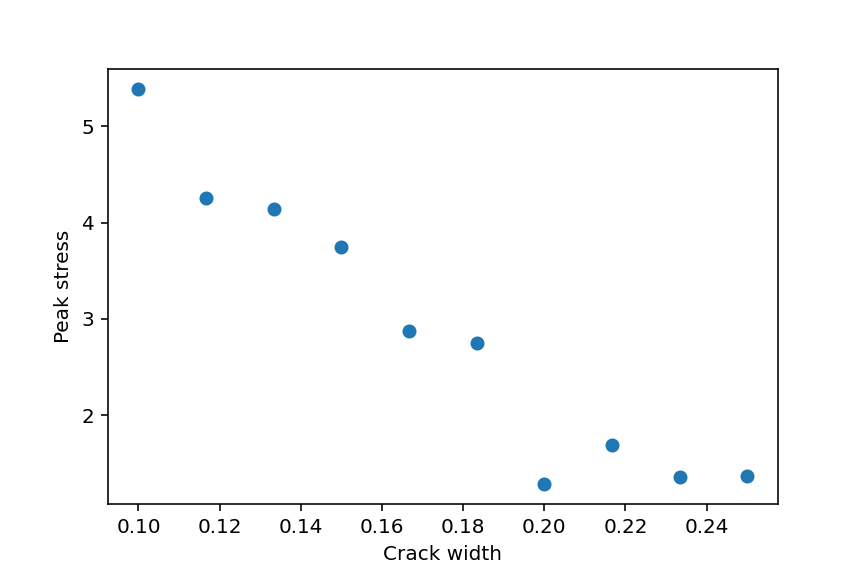

In [43]:
fig, ax = plt.subplots()
ax.scatter(widths, [job.output.von_Mises[-1].max() for job in width_jobs])
ax.set_xlabel('Crack width')
ax.set_ylabel('Peak stress');

## Exercise

Suppose that Al had the same bulk modulus, but double the shear modulus. What effect do you expect this to have on the maximum stresses across the different deformation modes? Repeat the quasistatic strain exercise for all three modes with `job.input.shear_modulus = 2 * G_Al` and compare these results to the original results. We'll keep $\lambda$ the same, as given below by modifying the bulk modulus.

In [44]:
new_G = 2 * G_Al
new_K = K_Al + (2 * G_Al / 3)

In [45]:
mode1t_shear = pr.create.job.FenicsLinearElastic('mode1t_shear', delete_existing_job=True)

mode1t_shear.input.bulk_modulus = new_K
mode1t_shear.input.shear_modulus = new_G
mode1t_shear.input.solver_parameters = mode1t.input.solver_parameters
mode1t_shear.input.mesh_resolution = mode1t.input.mesh_resolution

set_domain_to_cracked_box(mode1t_shear)

dirichlet_top = mode1t_shear.Expression(('0', 'a * t', '0'), degree=2, a=strain_step, t=0)
dirichlet_bot = mode1t_shear.Expression(('0', '-a * t', '0'), degree=2, a=strain_step, t=0)

top_bc = mode1t_shear.create.bc.dirichlet(dirichlet_top, top_half)
bottom_bc = mode1t_shear.create.bc.dirichlet(dirichlet_bot, bottom_half)
rigid_bc = mode1t_shear.create.bc.dirichlet(mode1t_shear.Constant((0, 0, 0)), near_end)
mode1t_shear.BC = [rigid_bc, top_bc, bottom_bc]

mode1t_shear.time_dependent_expressions.append(dirichlet_top)
mode1t_shear.time_dependent_expressions.append(dirichlet_bot)
mode1t_shear.input.n_steps = mode1t.input.n_steps

mode1t_shear.run()

The job mode1t_shear was saved and received the ID: 248
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [46]:
mode2t_shear = pr.create.job.FenicsLinearElastic('mode2t_shear', delete_existing_job=True)

mode2t_shear.input.bulk_modulus = new_K
mode2t_shear.input.shear_modulus = new_G
mode2t_shear.input.solver_parameters = mode1t.input.solver_parameters
mode2t_shear.input.mesh_resolution = mode1t.input.mesh_resolution

set_domain_to_cracked_box(mode2t_shear)

dirichlet_top = mode2t_shear.Expression(('0', '0', 'a * t'), degree=2, a=strain_step, t=0)
dirichlet_bot = mode2t_shear.Expression(('0', '0', '-a * t'), degree=2, a=strain_step, t=0)

top_bc = mode2t_shear.create.bc.dirichlet(dirichlet_top, top_half)
bottom_bc = mode2t_shear.create.bc.dirichlet(dirichlet_bot, bottom_half)
rigid_bc = mode2t_shear.create.bc.dirichlet(mode2t_shear.Constant((0, 0, 0)), near_end)
mode2t_shear.BC = [rigid_bc, top_bc, bottom_bc]

mode2t_shear.time_dependent_expressions.append(dirichlet_top)
mode2t_shear.time_dependent_expressions.append(dirichlet_bot)
mode2t_shear.input.n_steps = mode1t.input.n_steps

mode2t_shear.run()

The job mode2t_shear was saved and received the ID: 249


In [47]:
mode3t_shear = pr.create.job.FenicsLinearElastic('mode3t_shear', delete_existing_job=True)

mode3t_shear.input.bulk_modulus = new_K
mode3t_shear.input.shear_modulus = new_G
mode3t_shear.input.solver_parameters = mode1t.input.solver_parameters
mode3t_shear.input.mesh_resolution = mode1t.input.mesh_resolution

set_domain_to_cracked_box(mode3t_shear)

dirichlet_top = mode3t_shear.Expression(('a * t', '0', '0'), degree=2, a=strain_step, t=0)
dirichlet_bot = mode3t_shear.Expression(('-a * t', '0', '0'), degree=2, a=strain_step, t=0)

top_bc = mode3t_shear.create.bc.dirichlet(dirichlet_top, top_half)
bottom_bc = mode3t_shear.create.bc.dirichlet(dirichlet_bot, bottom_half)
rigid_bc = mode3t_shear.create.bc.dirichlet(mode3t_shear.Constant((0, 0, 0)), near_end)
mode3t_shear.BC = [rigid_bc, top_bc, bottom_bc]

mode3t_shear.time_dependent_expressions.append(dirichlet_top)
mode3t_shear.time_dependent_expressions.append(dirichlet_bot)
mode3t_shear.input.n_steps = mode1t.input.n_steps

mode3t_shear.run()

The job mode3t_shear was saved and received the ID: 250


<IPython.core.display.Javascript object>


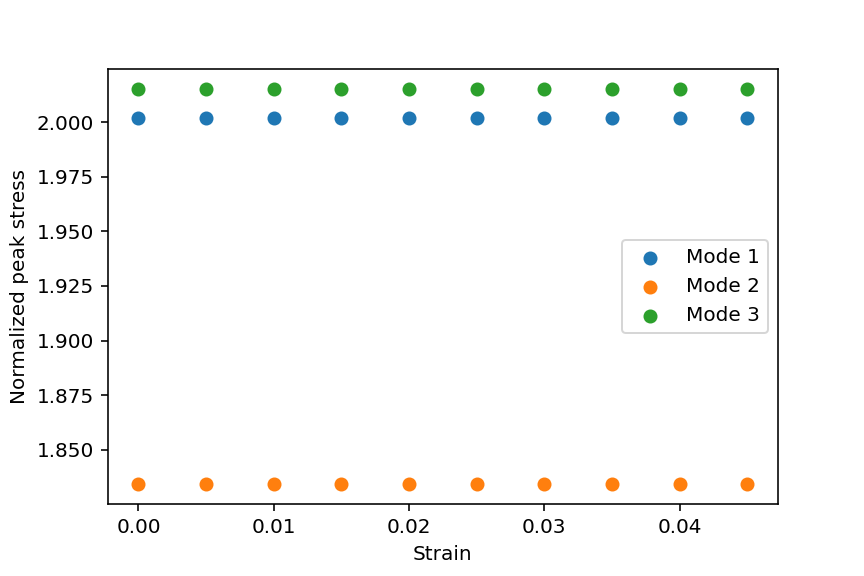

In [48]:
pal = sns.color_palette(n_colors=3)
fig, ax = plt.subplots()  
strain = strain_step * np.arange(mode1t.input.n_steps)

def max_vM(job):
    return np.array(job.output.von_Mises).max(axis=1)

ax.scatter(strain, max_vM(mode1t_shear) / max_vM(mode1t), label='Mode 1', marker='o', color=pal[0])
ax.scatter(strain, max_vM(mode2t_shear) / max_vM(mode2t), label='Mode 2', marker='o', color=pal[1])
ax.scatter(strain, max_vM(mode3t_shear) / max_vM(mode3t), label='Mode 3', marker='o', color=pal[2])
ax.set_xlabel('Strain')
ax.set_ylabel('Normalized peak stress')
ax.legend();